<a href="https://colab.research.google.com/github/kirubarajan/roft/blob/master/annotation/analysis/research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load from database

In [ ]:
!pip install fsspec gcsfs

     |████████████████████████████████| 125 kB 5.4 MB/s 
     |████████████████████████████████| 1.1 MB 11.6 MB/s 
     |████████████████████████████████| 160 kB 41.2 MB/s 
     |████████████████████████████████| 192 kB 41.3 MB/s 
     |████████████████████████████████| 271 kB 40.7 MB/s 


In [ ]:
import json
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set_theme(style="whitegrid")
sns.set_palette(sns.color_palette("Set2"))

DATABASE_DUMP_FILE = 'gs://roft_buckups/10-25-21.json'

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

In [ ]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

In [ ]:
with tf.io.gfile.GFile(DATABASE_DUMP_FILE, 'r') as f:
    lines = f.readlines()
    db = json.loads(lines[1])

def get_df(sql_model='core.annotation'):
    df = pd.DataFrame(db)
    df = df[df.model == sql_model]
    
    if 'date' in df.columns.values:
        df = df.set_index('date')

    return pd.json_normalize(df.fields).assign(pk=df.pk.values)

In [ ]:
df = pd.DataFrame(db)
print(set(df["model"].tolist()))

{'sessions.session', 'contenttypes.contenttype', 'core.dataset', 'core.playlist', 'core.profile', 'core.decodingstrategy', 'auth.user', 'core.feedbackoption', 'core.annotation', 'core.timestamp', 'admin.logentry', 'core.system', 'core.prompt', 'core.generation', 'auth.permission'}


### Load all the tables

In [ ]:
annotation_df = get_df()
profile_df = get_df('core.profile')
generation_df = get_df('core.generation')
prompt_df = get_df('core.prompt')
playlist_df = get_df('core.playlist')
decodingstrategy_df = get_df('core.decodingstrategy')
user_df = get_df('auth.user')

### Modify column names to avoid duplicates across tables.

In [ ]:
prompt_df = prompt_df.rename(columns={"body": "prompt_body"})
generation_df = generation_df.rename(columns={"body": "gen_body"})
decodingstrategy_df = decodingstrategy_df.rename(
    columns={"name": "dec_strat", "value": "dec_strat_value"})
annotation_df["date"] = pd.to_datetime(annotation_df["date"])

In [ ]:
generation_df["system"]

0           gpt2
1           gpt2
2           gpt2
3           gpt2
4           gpt2
          ...   
28542    davinci
28543    davinci
28544    davinci
28545    davinci
28546    davinci
Name: system, Length: 28547, dtype: object

### Merge all the relevant tables together.

In [ ]:
gen_to_playlist = {}
for idx, row in playlist_df.iterrows():
  shortname = row["shortname"]
  version = row["version"]
  generations = row["generations"]
  for gen_id in generations:
    gen_to_playlist[gen_id] = (shortname, version)

In [ ]:
full_df = annotation_df.join(generation_df.set_index('pk'), on='generation')
full_df = full_df.join(prompt_df.set_index('pk'), 'prompt')
full_df = full_df.join(decodingstrategy_df.set_index('pk'), 'decoding_strategy')

In [ ]:
playlist_names = [] 
playlist_versions = []
for idx, row in full_df.iterrows():
  gen_id = row["generation"]
  playlist_info = gen_to_playlist[gen_id]
  playlist_names.append(playlist_info[0])
  playlist_versions.append(playlist_info[1])
full_df["playlist_name"] = playlist_names
full_df["playlist_version"] = playlist_versions

### Filter out annotations not part of Version 2

In [ ]:
full_df = full_df[full_df.apply(lambda row: row["playlist_version"]=="0.2", axis=1)]

## Filter out unacceptable users
Methods for filtering out annotations for users who have NOT agreed to have their data analyzed (and filtering out us).

**TO HAVE YOUR PROFILE FILTERED OUT, PLEASE FILL OUT THE GOOGLE FORM AND SPECIFY "NO" TO THE QUESTION ABOUT WHETHER YOU WANT TO PARTICIPATE IN RESEARCH.**

In [ ]:
SURVEY_SPREADSHEET_ID = '1j9-nqsGFhpKSas_z1-IRKORlVbmjTzJ4_u_q6u-hOvg'
KEY = "ageed_to_research"
worksheet = gc.open_by_key(SURVEY_SPREADSHEET_ID).sheet1
rows = worksheet.get_all_values()

survey_df = pd.DataFrame.from_records(rows[1:], columns=rows[0])

survey_filter_df = survey_df[survey_df[KEY] == 'Yes']

# all the users who GAVE US PERMISSION
users_filter_df = user_df[user_df.username.isin(survey_filter_df["username"].values)]

# Filter all of the data frames that we use for analysis.
full_df = full_df[full_df.annotator.isin(users_filter_df.pk)]
annotation_df = annotation_df[annotation_df.annotator.isin(users_filter_df.pk)]

In [ ]:
full_df

,date,annotator,generation,playlist,boundary,points,attention_check,reason,pk,system,prompt,decoding_strategy,gen_body,prompt_body,num_sentences,dataset,prompt_index,dec_strat,dec_strat_value,playlist_name,playlist_version
112,2021-08-31 17:11:39.095000+00:00,1666,22877,-1,0,0,False,[9123971792800820313],113,finetuned,13803,1,"Meanwhile, combine all dressing ingredients in...",HOW TO MAKE: Baby Shell Pasta Salad With Kalam...,3,9,2130,top-p,0.4,Recipes,0.2
114,2021-08-31 17:12:40.795000+00:00,1666,21386,-1,9,5,False,[],115,gpt2-xl,16433,1,,HOW TO MAKE: Open Faced Italian Dogs\nIngredie...,10,10,9933,top-p,0.4,Recipes,0.2
138,2021-09-02 02:27:39.754000+00:00,1699,26262,-1,3,0,False,[repetition],139,finetuned,20538,1,Brush with malt syrup or sugar._SEP_Bake for 1...,HOW TO MAKE: Black Sesame Seed Bagels\nIngredi...,8,9,7824,top-p,0.4,Recipes,0.2
172,2021-09-02 13:41:57.862000+00:00,1720,1785,-1,1,0,False,[],173,gpt2,1810,1,It was probably because they were really old e...,Don't worry about credit- if anything always j...,8,1,2739,top-p,0.4,Short Stories,0.2
179,2021-09-02 13:44:42.769000+00:00,1727,26379,-1,1,0,False,[],180,finetuned,20654,1,Just increase the amount of walnuts to 2/3 cup...,HOW TO MAKE: Simply Elegant Green Beans\nIngre...,9,9,8030,top-p,0.4,Recipes,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46968,2021-10-18 04:36:47.625000+00:00,4433,26332,8,9,3,False,[],51458,finetuned,20608,1,The one serving is 12 ounces per person!_SEP_G...,HOW TO MAKE: Baked Salmon Fillets Dijon\nIngre...,8,9,7943,top-p,0.4,Recipes,0.2
46969,2021-10-18 04:37:01.490000+00:00,4433,22806,8,7,0,False,[generic],51459,finetuned,13785,1,Pour the boiling water over the chicken pieces...,HOW TO MAKE: Delicious Greek Garlic Chicken\nI...,3,9,2017,top-p,0.4,Recipes,0.2
46970,2021-10-18 04:37:12.887000+00:00,4433,24651,8,9,0,False,[],51460,finetuned,19077,1,Transfer the biscuits to the prepared baking s...,HOW TO MAKE: Cheddar-Polenta Biscuits with Ham...,5,9,4999,top-p,0.4,Recipes,0.2
46971,2021-10-18 04:37:24.752000+00:00,4433,20136,8,9,0,False,[],51461,gpt2-xl,15183,1,Melt the remaining 4 tablespoons butter in a l...,HOW TO MAKE: Asparagus Omelette\nIngredients:\...,2,10,1396,top-p,0.4,Recipes,0.2


# Dataset Statistics

In [ ]:
full_df.groupby('playlist_name').count()

,date,annotator,generation,playlist,boundary,points,attention_check,reason,pk,system,prompt,decoding_strategy,gen_body,prompt_body,num_sentences,dataset,prompt_index,dec_strat,dec_strat_value,playlist_version
playlist_name,,,,,,,,,,,,,,,,,,,,
New York Times,4957,4957,4957,4957,4957,4957,4957,4957,4957,4957,4957,4957,4957,4957,4957,4957,4957,4957,4957,4957
Presidential Speeches,5098,5098,5098,5098,5098,5098,5098,5098,5098,5098,5098,5098,5098,5098,5098,5098,5098,5098,5098,5098
Recipes,12186,12186,12186,12186,12186,12186,12186,12186,12186,12186,12186,12186,12186,12186,12186,12186,12186,12186,12186,12186
Short Stories,5230,5230,5230,5230,5230,5230,5230,5230,5230,5230,5230,5230,5230,5230,5230,5230,5230,5230,5230,5230


# Helper Functions

In [ ]:
def map_playlist_name(playlist):
  """Converts playlist names to the ones we want to use in the paper."""
  if playlist == 'New York Times':
    return "News"
  elif playlist == 'Presidential Speeches':
    return "Speeches"
  elif playlist == 'Recipes':
    return "Recipes"
  elif playlist == 'Short Stories':
    return "Stories"

def save(filename):
  plt.tight_layout()
  plt.savefig(filename)
  plt.show()

In [ ]:
# out_path = /tmp/point_distribution
%download_file /tmp/point_distribution


UsageError: Line magic function `%download_file` not found.


# Analysis

## Mean points

In [ ]:
def analyze_per_playlist():
  info_to_return = []
  playlist_names = set(playlist_df["shortname"].tolist())
  model_names = set(generation_df["system"].tolist())
  for playlist in playlist_names:
    for model in model_names:
      df = full_df[(full_df["playlist_name"]==playlist) & 
                          (full_df["system"]==model) &
                          (full_df["playlist_version"]=="0.2")]
      
      if len(df) > 0:
        info = {"playlist": playlist,
                "model": model,
                "mean score": np.mean(df["points"]),
                "median score": np.median(df["points"]),
                "fraction_nonzero": len(df[df["points"] > 0]) / len(df),
                "num_annotations": len(df)
        }
        info_to_return.append(info)
  return pd.DataFrame(info_to_return)

analyze_per_playlist()

,playlist,model,mean score,median score,fraction_nonzero,num_annotations
0,Recipes,gpt2-xl,2.067023,0.0,0.479583,7102
1,Recipes,finetuned,1.924421,1.0,0.513056,10876
2,Presidential Speeches,ctrl,2.205159,2.0,0.587175,8374
3,Short Stories,davinci,1.842697,1.0,0.629213,89
4,Short Stories,gpt2-xl,1.765329,1.0,0.514383,2642
5,Short Stories,gpt2,2.046058,1.0,0.512889,5276
6,New York Times,easy,2.697248,3.0,0.712538,327
7,New York Times,gpt2-xl,1.817623,1.0,0.511165,7479


In [ ]:
def analyze_per_decoding_strat():
  info_to_return = []
  playlist_names = set(playlist_df["shortname"].tolist())
  model_names = set(generation_df["system"].tolist())
  for playlist in playlist_names:
    for model in model_names:
      for top_p_value in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        df = full_df[(full_df["dec_strat"]=="top-p") &
                  (full_df["dec_strat_value"]==top_p_value) &
                  (full_df["playlist_name"]==playlist) &
                  (full_df["system"]==model) &
                          (full_df["playlist_version"]=="0.2")]

        if len(df) > 0:
          info = {"p-value": top_p_value,
                  "playlist": playlist,
                  "model": model,
                  # "mean score": np.mean(df["points"]),
                  # "std score": np.std(df["points"]),
                  "mean_score": "%0.2f\\pm%0.2f" % (np.mean(df["points"]), np.std(df["points"])),
                  "median score": np.median(df["points"]),
                  "fraction_nonzero": len(df[df["points"] > 0]) / len(df),
                  "num_annotations": len(df),
          }
          info_to_return.append(info)
  return pd.DataFrame(info_to_return)

out_df = analyze_per_decoding_strat() 
out_df

,p-value,playlist,model,mean_score,median score,fraction_nonzero,num_annotations
0,0.0,New York Times,gpt2-xl,1.67\pm1.95,0.0,0.491773,1641
1,0.4,New York Times,gpt2-xl,1.76\pm1.97,1.0,0.507246,1518
2,1.0,New York Times,gpt2-xl,2.09\pm2.08,2.0,0.568182,1584
3,0.0,Short Stories,gpt2-xl,1.55\pm1.88,0.0,0.484155,568
4,0.4,Short Stories,gpt2-xl,1.88\pm2.02,1.0,0.543230,613
5,1.0,Short Stories,gpt2-xl,2.38\pm2.04,3.0,0.643739,567
6,0.4,Short Stories,davinci,1.85\pm1.87,1.0,0.621622,74
7,0.4,Short Stories,gpt2,2.17\pm2.18,2.0,0.538732,3408
8,0.4,Presidential Speeches,ctrl,2.12\pm2.10,2.0,0.571793,5098
9,0.4,Recipes,gpt2-xl,2.16\pm2.34,0.0,0.496161,4819


### Comparison of XL models across p-values for NYT and Reddit

**Conclusion**: Sampling from full distribution (p=1.0) has worse quality. Argmax sampling (with repetition penalty) seems to be consistently better for text quality -- this is consistent with Daphne's research.

Text(0, 0.5, 'Mean Score')

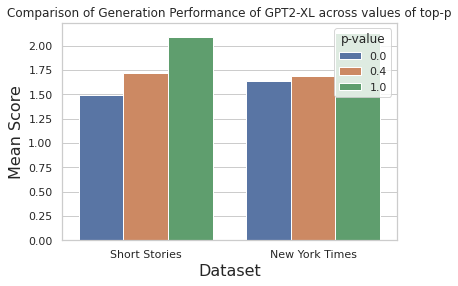

In [ ]:
p = sns.barplot(x="playlist", y="mean score", hue="p-value", data=out_df[(out_df["model"]=="gpt2-xl") & (out_df["playlist"]=="Short Stories") | (out_df["playlist"]=="New York Times")])
p.set_title("Comparison of Generation Performance of GPT2-XL across values of top-p")
p.set_xlabel("Dataset", fontsize = 16)
p.set_ylabel("Mean Score", fontsize = 16)

### Comparison of GPT2-XL p=0.4 across reddit, nyt, and recipes

**Conclusion:** We see that Recipes are the most difficult, then NYT and short stories. This shows that generation systems struggle with structured text and are better at more open-ended generations (?). Also shows that domain knowledge is important. (although NYT being better than reddit is interesting).

Text(0, 0.5, 'Mean Score')

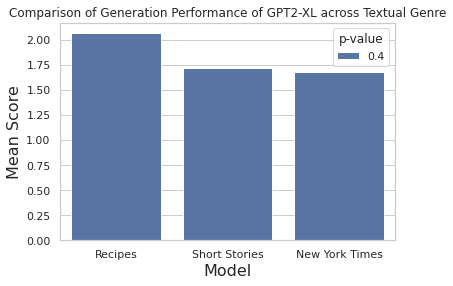

In [ ]:
p = sns.barplot(x="playlist", y="mean score", hue="p-value", data=out_df[(out_df["model"]=="gpt2-xl") & (out_df["p-value"]==0.4)])
p.set_title("Comparison of Generation Performance of GPT2-XL across Textual Genre")
p.set_xlabel("Model", fontsize = 16)
p.set_ylabel("Mean Score", fontsize = 16)

### Comparison of Model Size across same dataset and p-value

**Conclusion**: Bigger Models are better (good sanity check, nice to know this is confirmed) -- don't use GPT3 here because we only have 89 annotations

Text(0, 0.5, 'Mean Score')

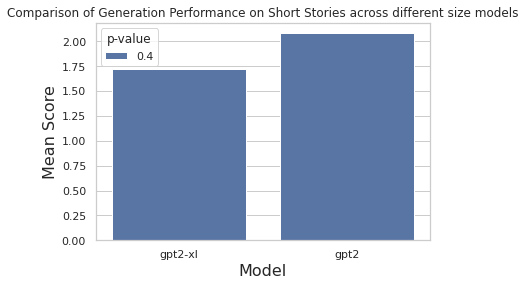

In [ ]:
p = sns.barplot(x="model", y="mean score", hue="p-value", data=out_df[(out_df["playlist"]=="Short Stories") & (out_df["p-value"]==0.4) & (out_df["model"]!="davinci")])
p.set_title("Comparison of Generation Performance on Short Stories across different size models")
p.set_xlabel("Model", fontsize = 16)
p.set_ylabel("Mean Score", fontsize = 16)

### Comparison of fine-tuning performance

Text(0, 0.5, 'Mean Score')

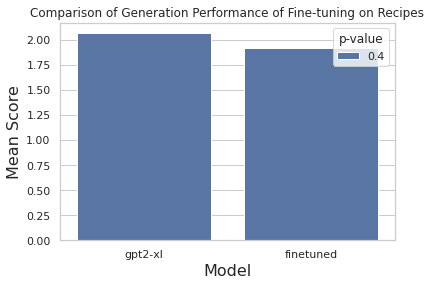

In [ ]:
p = sns.barplot(x="model", y="mean score", hue="p-value", data=out_df[(out_df["playlist"]=="Recipes")])
p.set_title("Comparison of Generation Performance of Fine-tuning on Recipes")
p.set_xlabel("Model", fontsize = 16)
p.set_ylabel("Mean Score", fontsize = 16)

### Mean points on easy baseline NYTimes 

In [ ]:
full_df["

### Mean Points for only the first 10 annotations from each annotator


## Point Distributions

### Per playlist

In [ ]:
full_df[full_df["system"] == "easy"].points.mean()

2.7523364485981308

In [ ]:
import collections

In [ ]:
df = full_df[full_df["system"].isin(('ctrl', 'finetuned', 'gpt2-xl'))]
df = df[df["dec_strat_value"] == 0.4]

playlists = set(df["playlist_name"].tolist())
to_plot = []
for playlist in playlists:
  print(playlist)
  points = df[df["playlist_name"]==playlist].points.tolist()
  points = collections.Counter(points)

  heights = np.array(list(points.values())) / sum(points.values())
  for point_value, height in zip(points, heights):
    to_plot.append({"Points earned": point_value,
                    "Fraction of annotations":height,
                    "Domain": map_playlist_name(playlist)})
  # plt.bar(x=points.keys(), height=height)
  # plt.ylim([0, 0.5])
  # plt.show()

New York Times
Short Stories
Presidential Speeches
Recipes


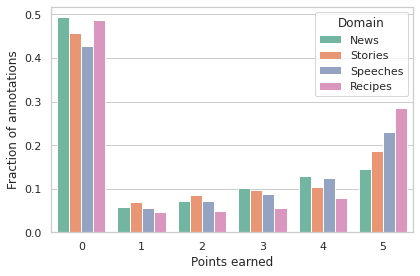

In [ ]:
to_plot = pd.DataFrame(to_plot)
sns.barplot(x="Points earned", y="Fraction of annotations", hue="Domain", data=to_plot)
save("point_distribution.pdf")

### Per annotator

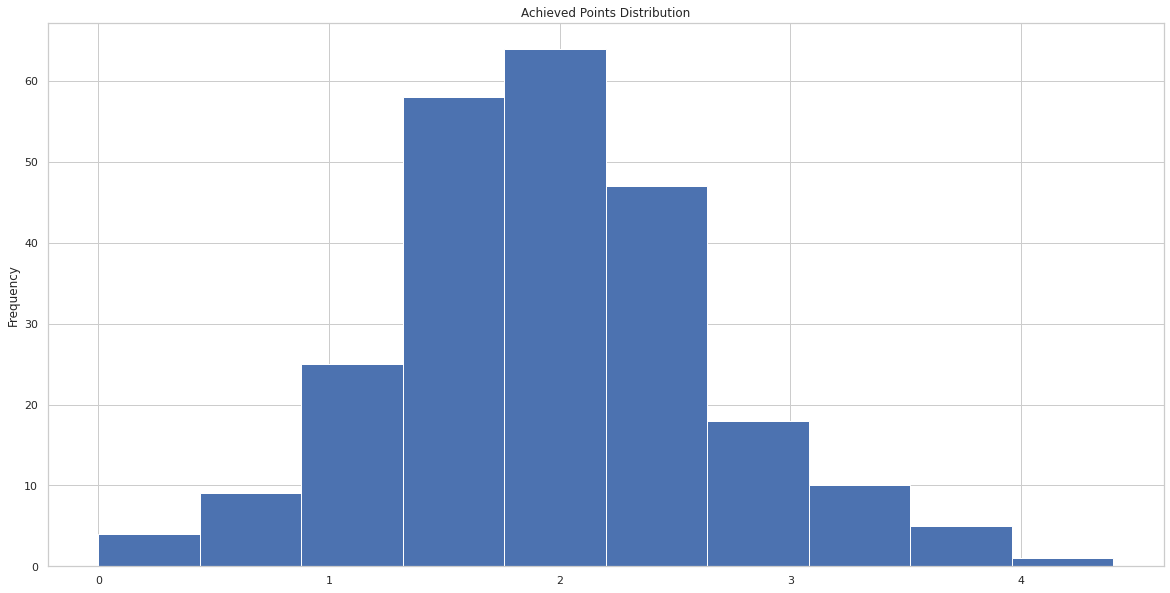

In [ ]:
full_df.sort_values(['date']).groupby('annotator').points.mean().plot.hist(
    figsize=(20, 10),
    title='Achieved Points Distribution'
)

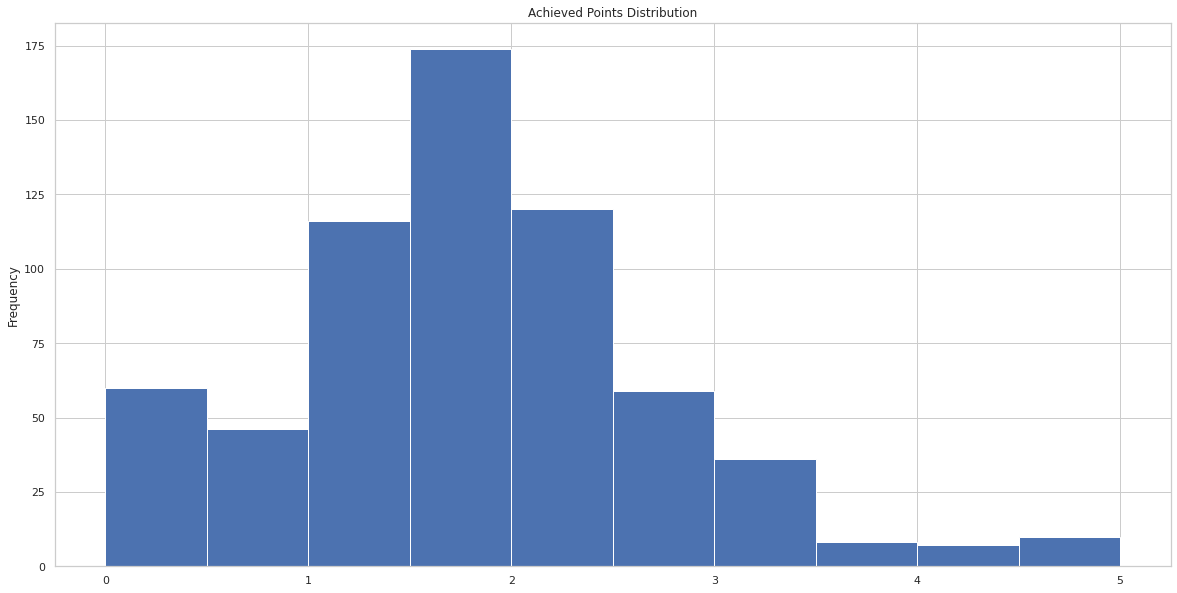

In [ ]:
full_df.groupby('annotator').points.mean().plot.hist(
    figsize=(20, 10),
    title='Achieved Points Distribution'
)

## Anotator performance over time

Of the annotators who did at least K annotations, plot their mean score over time

In [ ]:
df = annotation_df.groupby('annotator').count()

In [ ]:
def analyze_progress(df, k=50):
  """Analyze whether annotators improve in aggregate over k annotations."""
  all_score_series = []
  annotators = df[df["pk"] > k].reset_index()["annotator"].tolist()
  for annotator in annotators:
    annotations = annotation_df[annotation_df["annotator"] == annotator]
    score_series = annotations.sort_values("date")["points"][:k].tolist()
    all_score_series.append(score_series)

  return np.array(all_score_series), len(annotators)

In [ ]:
def analyze_and_plot(s, n, k):
  print(n)
  data = np.array(s)
  data = np.mean(data, axis=0)
  print("spearmanr: %.2f, %f" % stats.spearmanr(range(k), data))
  print("pearsonr: %.2f, %f" % stats.pearsonr(range(k), data))
  plt.plot(range(1, k+1), data)
  plt.ylabel("Mean score")
  plt.xlabel("$n$th annotation")
  plt.title("Performance over time")
  plt.show()

### Analysis of annotators getting better over time (1st Batch)

**Conclusion**: We see no correlation on the first batch of annotators. They do not improve over time

23
spearmanr: -0.16, 0.276470
pearsonr: -0.11, 0.462299


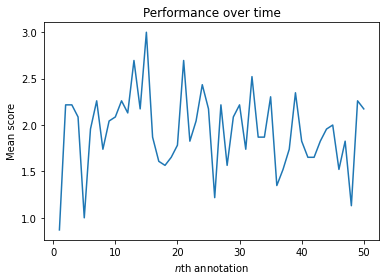

In [ ]:
k = 50
s, n = analyze_progress(full_df[(full_df['date'] < '2021-10-1')].groupby('annotator').count(), k)
analyze_and_plot(s, n, k)

13
spearmanr: -0.04, 0.685869
pearsonr: -0.02, 0.862583


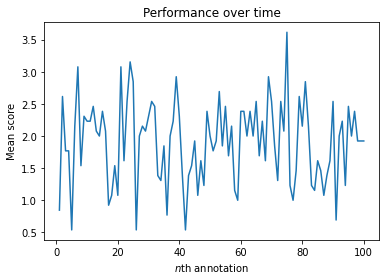

In [ ]:
k = 100
s, n = analyze_progress(full_df[(full_df['date'] < '2021-10-1')].groupby('annotator').count(), k)
analyze_and_plot(s, n, k)

4
spearmanr: -0.03, 0.710323
pearsonr: 0.00, 0.950708


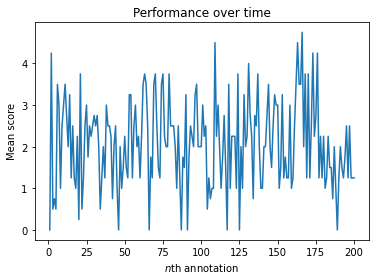

In [ ]:
k = 200
s, n = analyze_progress(full_df[(full_df['date'] < '2021-10-1')].groupby('annotator').count(), k)
analyze_and_plot(s, n, k)

### Analysis of annotators getting better over time (2nd Batch)

**Conclusion**: We actually see a positive correlation (over 0.3) for k=50, 100, and 200 on the second batch of annotators. They DO actually improve over time. This suggests that, with the correct instructions, annotators may be able to be taught how to improve at detecting generated text.

92
spearmanr: 0.44, 0.001287
pearsonr: 0.39, 0.005204


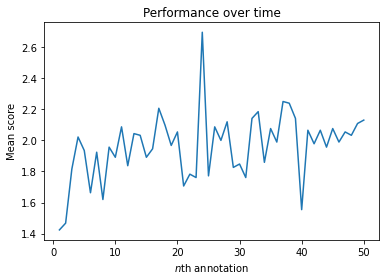

In [ ]:
k = 50
s, n = analyze_progress(full_df[(full_df['date'] > '2021-10-1')].groupby('annotator').count(), k)
analyze_and_plot(s, n, k)

87
spearmanr: 0.60, 0.000000
pearsonr: 0.59, 0.000000


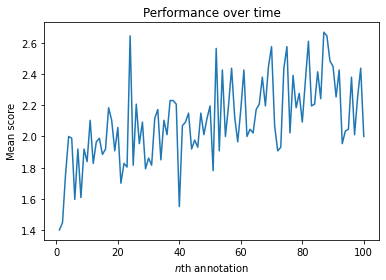

In [ ]:
k = 100
s, n = analyze_progress(full_df[(full_df['date'] > '2021-10-1')].groupby('annotator').count(), k)
analyze_and_plot(s, n, k)

54
spearmanr: 0.35, 0.000001
pearsonr: 0.34, 0.000001


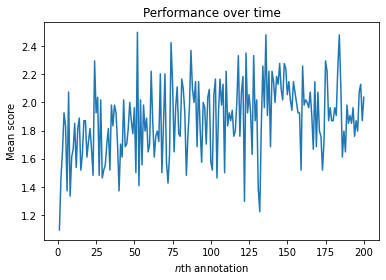

In [ ]:
k = 200
s, n = analyze_progress(full_df[(full_df['date'] > '2021-10-1')].groupby('annotator').count(), k)
analyze_and_plot(s, n, k)

## Inter-annotator agreement

### Fraction agreement
For every pair of annotators who annotated the same generaton, what fraction guessed the same boundary?

In [ ]:
annotations_per_gen = annotation_df.groupby('generation')
# 
num_annotations_per_gen = annotations_per_gen.points.count()


In [ ]:
def analyze_fraction_agreements():
  generation_ids = set(annotation_df["generation"].tolist())
  annotations_per_gen = annotation_df.groupby('generation')

  overall_num_annotations = 0
  overall_num_agreements = 0

  x = annotations_per_gen.boundary.value_counts()
  for idx, generation in enumerate(generation_ids):
    chosen_boundaries = x[generation]
    chosen_boundaries = {k: chosen_boundaries[k] for k in chosen_boundaries.keys()}
    
    total_annotations = sum(chosen_boundaries.values())
    if total_annotations > 1:
      total_agreements = sum(v for v in chosen_boundaries.values() if v > 1)

      overall_num_annotations += total_annotations
      overall_num_agreements += total_agreements

  print("Out of {} total annotations on generations with >1 annotation, {} were in agreement with another annotation on the true boundary position. That is {}".format(
      overall_num_annotations, overall_num_agreements, overall_num_agreements/overall_num_annotations
  ))
analyze_fraction_agreements()

# TODO: Figure out what the baseline of random guessing would be,

Out of 13915 total annotations on generations with >1 annotation, 6275 were in agreement with another annotation on the true boundary position. That is 0.4509522098454905


### Krippendorf's Alpha

In [ ]:
import nltk.metrics

In [ ]:
from nltk.metrics.agreement import AnnotationTask

In [ ]:
# df = annotation_df.groupby('generation').boundary.apply(list).reset_index()
# df = df[df.apply(lambda row: len(row["boundary"]) >= 4, axis=1)]

# df

In [ ]:
annotation_data = []
for idx, row in annotation_df.iterrows():
  coder = row["annotator"]
  item = row["generation"]
  label = row["boundary"]
  annotation_data.append((coder,item,label))

In [ ]:
ann_task = AnnotationTask(annotation_data)

In [ ]:
print(ann_task.alpha())

## Profile Statistics

In [ ]:
def user_stats(df, name):
  data = {"name": name}
  data["num_participants"] = len(np.unique(df["annotator"]).tolist())
  data["num_annotations"] = len(df)
  data["mean_annotations_per_participant"] = data["num_annotations"] / data["num_participants"] 
  data["mean_points"] = np.mean(df["points"])
  data["std_points"] = np.std(df["points"])
  return data

In [ ]:
all_data = []
all_data.append(user_stats(full_df, "overall"))

### First batch

In [ ]:
df = full_df[(full_df['date'] <= '2021-10-1')]
all_data.append(user_stats(df, "Section A"))

### Second batch

In [ ]:
df = full_df[(full_df['date'] > '2021-10-1')]
all_data.append(user_stats(df, "Section B"))

In [ ]:
pd.DataFrame(all_data)

,name,num_participants,num_annotations,mean_annotations_per_participant,mean_points,std_points
0,overall,241,27471,113.987552,2.037312,2.146544
1,Section A,141,7264,51.517730,1.947274,2.147596
2,Section B,102,20207,198.107843,2.069679,2.145242


In [ ]:
profile_df.is_temporary.mean()

0.9116865869853917

# Time Tracking Analysis

In [ ]:
timing_df = df[df.model == 'core.timestamp']
timing_df = pd.json_normalize(timing_df.fields).rename(columns={'date': 'timestamp'}).merge(full_df, left_on='annotation', right_on='pk')

In [ ]:
time_df = pd.DataFrame(timing_df[['annotation', 'timestamp', 'dec_strat_value', 'dec_strat', 'points', 'gen_body', 'playlist_name', 'system']])
time_df['timestamp'] = pd.to_datetime(time_df.timestamp)
time_df['delta'] = time_df.timestamp - time_df.timestamp.shift(1)
time_df['delta'] = time_df.delta.dt.seconds
time_df = time_df[time_df.delta < 120]

## Median Time Delta

In [ ]:
time_df.delta.median()

2.0

## Correlation Between Time Delta and Decoding Hyperparameter (top-p)

In [ ]:
time_df[['dec_strat_value', 'delta']].corr()

,dec_strat_value,delta
dec_strat_value,1.000000,-0.001124
delta,-0.001124,1.000000


## Time Delta Distribution

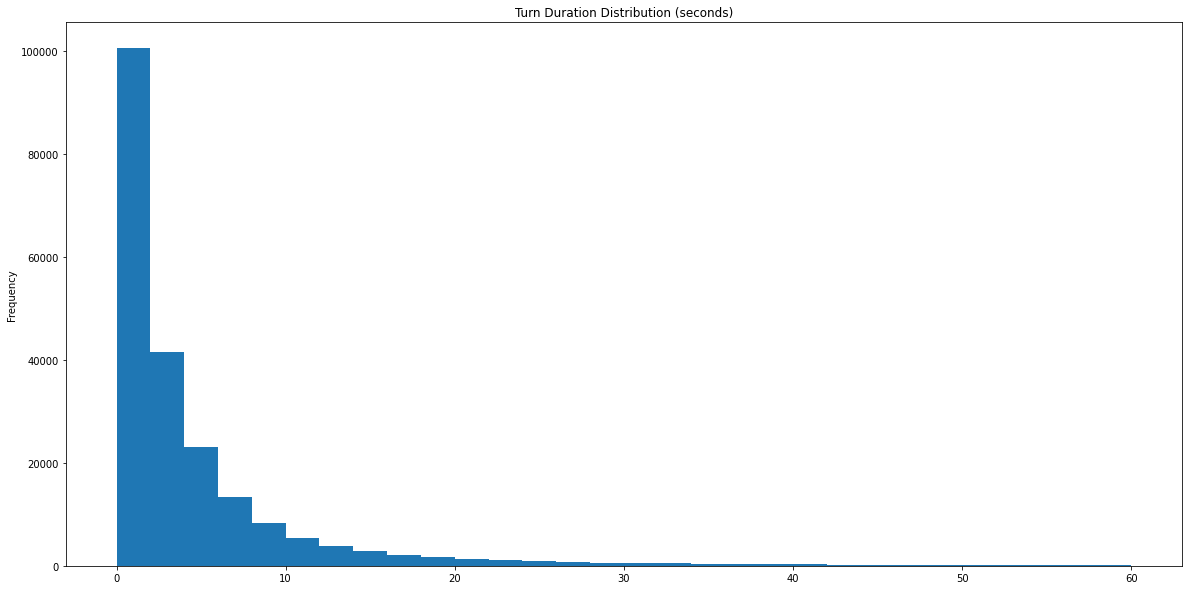

In [ ]:
time_df.delta.plot(
    kind='hist',
    range=(0, 60),
    bins=30,
    figsize=(20, 10),
    title=('Turn Duration Distribution (seconds)')
  )

## Correlation Between Time Delta and Sentence Length

In [ ]:
time_df['gen_body_length'] = time_df.gen_body.str.len()
time_df.groupby('annotation').agg({'delta': 'sum', 'gen_body_length': 'mean'}).corr()

,delta,gen_body_length
delta,1.000000,-0.022575
gen_body_length,-0.022575,1.000000


## Correlation Between Time Delta and Points

In [ ]:
time_df.groupby('annotation').agg({'delta': 'sum', 'points': 'mean'}).corr()

,delta,points
delta,1.000000,0.101382
points,0.101382,1.000000


## Comparison of Average Time Deltas Between Text Domains

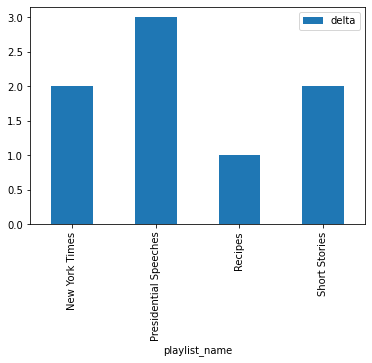

In [ ]:
# Median
time_df.groupby('playlist_name').agg({'delta': 'median'}).plot.bar()

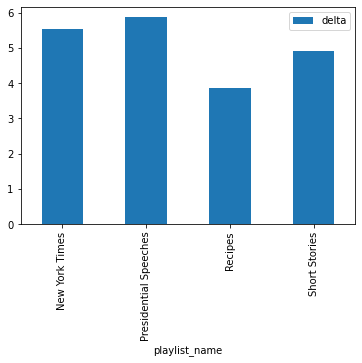

In [ ]:
# Mean
time_df.groupby('playlist_name').agg({'delta': 'mean'}).plot.bar()

## Comparison of Average Time Deltas Between Models

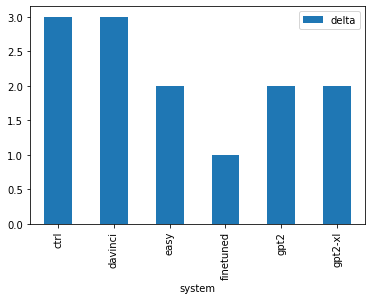

In [ ]:
# Median
time_df.groupby('system').agg({'delta': 'median'}).plot.bar()

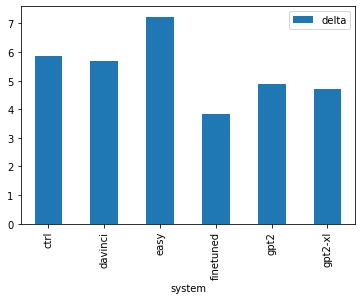

In [ ]:
# Mean
time_df.groupby('system').agg({'delta': 'mean'}).plot.bar()